Objective: Implementing a model to classify the digits

Data Source: MNIST digits data from sklearn dataset   

In [68]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report


## Load the MNIST digits data

In [2]:
# Get MNIST digits data from sklearn dataset
data = fetch_openml('mnist_784', version=1)

# check the column names of the data
print(data.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


## Data preparation

In [3]:
# select the dependent and independent data
X = data['data']
y = data['target']

# null values check
print(f'number of cells with null values: {sum(pd.DataFrame(X).isnull().sum())}')

print(f'The size of the data (#examples, #features) :{X.shape}')
print(f'Classes in the target y: {np.unique(y)}')


number of cells with null values: 0
The size of the data (#examples, #features) :(70000, 784)
Classes in the target y: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


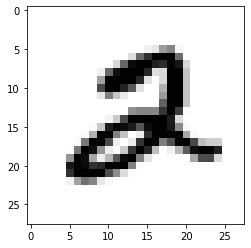

In [4]:
# Simple check of an image of a digit
imdata = X[5].reshape(28, 28)
plt.imshow(imdata, cmap=mpl.cm.binary)

## Split the data, and train the model for a binary classification of the digit 5


In [5]:
X_train, X_test= X[:60000], X[60000:]
y_train, y_test = y[:60000].astype(np.int8), y[60000:].astype(np.int8)

# Consider a simple case for binary classification whether the given image contains digit 5 or not
y_train = (y_train==5)
y_test = (y_test==5)

### Linear classifier

In [6]:
lrc = LogisticRegression(solver='liblinear')
lrc.fit(X_train, y_train)

# predict whether a given digit is 5 or not
lrc.predict([X_test[10]])

# linear model performance
y_pred = lrc.predict(X_test)
n_correct = sum(y_pred==y_test)
accuracy = n_correct / len(y_test)
print(f'accuracy: {accuracy}')

# confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

accuracy: 0.9774
[[9027   81]
 [ 145  747]]
              precision    recall  f1-score   support

       False       0.98      0.99      0.99      9108
        True       0.90      0.84      0.87       892

    accuracy                           0.98     10000
   macro avg       0.94      0.91      0.93     10000
weighted avg       0.98      0.98      0.98     10000



From the above metrics:
- The accuracy of the model is approximately 98% but the 84% recall indicates the model could not identify the digit 5 in several cases.
- 9027 test instances of class non-5 images are predicted correctly but 81 instances are in-correctly classified as images of the 5. So the true negatives are 9027 while the false positives are 81
- 145 images of the class 5 are classified as images of the non-5s so the false nagtives are 145
- 747 of the images of 5s are classfied as images of the 5s so the true positives are 747


### Cross-validation scores

In [7]:
# use cross validation data to measure the score of the model
kfold = StratifiedKFold(n_splits=3)
y_predict = cross_val_predict(lrc, X_train, y_train, cv=kfold, method='decision_function')

Required precision: 0.9 
Recall : 0.7756871425936174


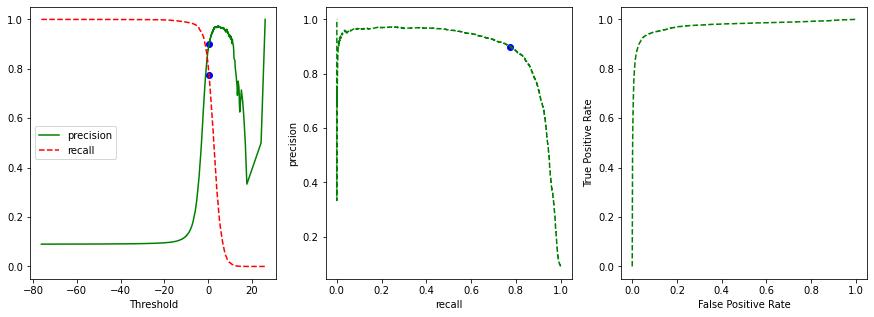

Area under curve of the ROC: 0.973650750997323


In [9]:
# derive and plot the threshold, precision, recall values
precisions, recalls, thresholds = precision_recall_curve(y_train, y_predict)

# Plot between precision (and recall) and threshold
req_precision = 0.9
threshold_90_precision = thresholds[np.argmax(precisions>=req_precision)]
recall_90_precision = recalls[np.argmax(precisions>=req_precision)]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(thresholds, precisions[:-1], 'g', label='precision')
ax1.plot(thresholds, recalls[:-1], 'r--', label='recall')
ax1.scatter(threshold_90_precision, req_precision, c='blue')
ax1.scatter(threshold_90_precision, recall_90_precision, c='blue')
ax1.set(xlabel='Threshold')
ax1.legend()

# Plot between precision and recall
ax2.plot(recalls, precisions, 'g--')
ax2.set(xlabel='recall', ylabel='precision')
ax2.scatter(recall_90_precision, req_precision, c='blue')
print(f'Required precision: {req_precision} \nRecall : {recall_90_precision}')

# ROC curve
fpr, tpr, thresholds = roc_curve(y_train, y_predict)
lrc_auc = roc_auc_score(y_train, y_predict)
ax3.plot(fpr, tpr, 'g--')
ax3.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
plt.show()
print(f'Area under curve of the ROC: {lrc_auc}')

Higher area of the ROC curve indicates that the model much better than the random guess model (its area of ROC is 0.5). However, if one wants to have high recall rate (>90%), there will be more false positives.

### SVM, Randm Forest Classifier, Gradient Boosting Classifier

In [10]:
models = [('sgd', SGDClassifier()),
          ('rfc', RandomForestClassifier()),
          ('gbc', GradientBoostingClassifier())] 
         # dafault loss function for SGD is hinge (SVM)

kfold = StratifiedKFold(n_splits=3)    
precision_train, recall_train, roc_area_train = ([], [], [])
precision_test, recall_test, roc_area_test = ([], [], [])
for name, model in models:
    y_predict = cross_val_predict(model, X_train, y_train, cv=kfold)
    
    precision_train.append(precision_score(y_train, y_predict))
    recall_train.append(recall_score(y_train, y_predict))
    roc_area_train.append(roc_auc_score(y_train, y_predict))
    
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    precision_test.append(precision_score(y_test, y_predict))
    recall_test.append(recall_score(y_test, y_predict))
    roc_area_test.append(roc_auc_score(y_test, y_predict))

In [11]:
print(f'model\t\t|precision\t\t|recall\t\t\t|roc_area')
for i, (name, model) in enumerate(models):
    print(f'{name}_train\t|{precision_train[i]}\t|{recall_train[i]}\t|{roc_area_train[i]}')
for i, (name, model) in enumerate(models):
    print(f'{name}_test\t|{precision_test[i]}\t|{recall_test[i]}\t|{roc_area_test[i]}')

model		|precision		|recall			|roc_area
sgd_train	|0.8148905706688484	|0.7349197565024903	|0.8591691437196487
rfc_train	|0.9896885521885522	|0.8675521121564287	|0.933327165479266
gbc_train	|0.9642627862187032	|0.8312119535141118	|0.914076084307579
sgd_test	|0.8319719953325554	|0.7993273542600897	|0.8917585387901238
rfc_test	|0.9948652118100129	|0.8688340807174888	|0.9341974531826355
gbc_test	|0.9708994708994709	|0.8228699551569507	|0.9102272481098763


From the observations of the prediction case of the test data, we can say that the recall rate from the random forest classifier (87%) is slightly improved compared to the logistic regression classifier (84%).

###  Scaled Data - SVM, Randm Forest Classifier, Gradient Boosting Classifier

In [83]:
X_train, X_test= X[:60000], X[60000:]
y_train, y_test = y[:60000].astype(np.int8), y[60000:].astype(np.int8)

# feature scaling
ssc = StandardScaler().fit(X_train)
X_train = ssc.transform(X_train)
X_test = ssc.transform(X_test)

# Consider a simple case for binary classification whether the given image contains digit 5 or not
y_train = (y_train==5)
y_test = (y_test==5)

In [13]:
models = [('sgd', SGDClassifier()),
          ('rfc', RandomForestClassifier()),
          ('gbc', GradientBoostingClassifier())] 
         # dafault loss function for SGD is hinge (SVM)

kfold = StratifiedKFold(n_splits=3)    
precision_train, recall_train, roc_area_train = ([], [], [])
precision_test, recall_test, roc_area_test = ([], [], [])
for name, model in models:
    y_predict = cross_val_predict(model, X_train, y_train, cv=kfold)
    
    precision_train.append(precision_score(y_train, y_predict))
    recall_train.append(recall_score(y_train, y_predict))
    roc_area_train.append(roc_auc_score(y_train, y_predict))
    
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    precision_test.append(precision_score(y_test, y_predict))
    recall_test.append(recall_score(y_test, y_predict))
    roc_area_test.append(roc_auc_score(y_test, y_predict))

In [14]:
print(f'model\t\t|precision\t\t|recall\t\t\t|roc_area')
for i, (name, model) in enumerate(models):
    print(f'{name}_train\t|{precision_train[i]}\t|{recall_train[i]}\t|{roc_area_train[i]}')
for i, (name, model) in enumerate(models):
    print(f'{name}_test\t|{precision_test[i]}\t|{recall_test[i]}\t|{roc_area_test[i]}')

model		|precision		|recall			|roc_area
sgd_train	|0.8667081260364843	|0.7712599151448072	|0.8797394135902858
rfc_train	|0.9882673371045464	|0.8701346615015679	|0.9345543129234144
gbc_train	|0.9646832191780822	|0.8313964213244789	|0.9141866402780257
sgd_test	|0.8814814814814815	|0.8004484304932735	|0.8949541230200229
rfc_test	|0.9923857868020305	|0.8766816143497758	|0.9380114264107244
gbc_test	|0.9709379128137384	|0.8239910313901345	|0.9107877862264682


A slight improvement can be observed in the recall rate for the logistic and radom forest classifiers.

## Multiclass Classifier - Random Forest Classifier

In [20]:
# sklearn automatically performs the binary classification for multiclass classification system
X_train, X_test= X[:60000], X[60000:]
y_train, y_test = y[:60000].astype(np.int8), y[60000:].astype(np.int8)

# feature scaling
ssc = StandardScaler().fit(X_train)
X_train = ssc.transform(X_train)
X_test = ssc.transform(X_test)

In [64]:
rfc = RandomForestClassifier()
kfold = StratifiedKFold(n_splits=3)
y_predict = cross_val_predict(rfc, X_train, y_train, cv=kfold)

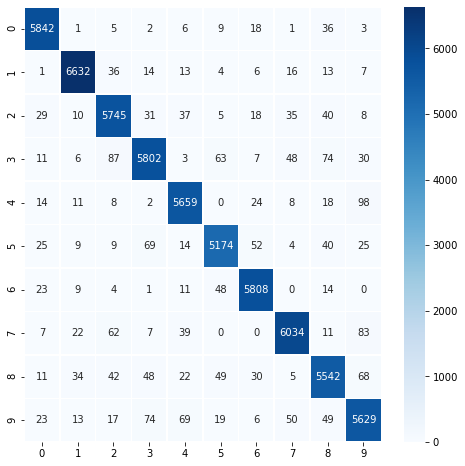

,precision,recall,f1-score,support
0,0.975944,0.986324,0.981107,5923.00000
1,0.982955,0.983684,0.983320,6742.00000
2,0.955112,0.964250,0.959659,5958.00000
3,0.959008,0.946338,0.952631,6131.00000
4,0.963562,0.968675,0.966112,5842.00000
5,0.963322,0.954436,0.958858,5421.00000
6,0.973027,0.981413,0.977202,5918.00000
7,0.973069,0.963128,0.968073,6265.00000
8,0.949460,0.947189,0.948323,5851.00000
9,0.945891,0.946209,0.946050,5949.00000


In [63]:
cm = confusion_matrix(y_train, y_predict)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidth=0.5)
plt.show()

res = pd.DataFrame(classification_report(y_train, y_predict, output_dict=True)).T
res

## Hyperparameter tuning

In [80]:
param_grid = { 
    'n_estimators':[100, 500, 1000],
    'max_features': ['auto', 'sqrt','log2'],
    'max_depth' : [10,20, 30, 40, 50],
    'min_samples_leaf':[2, 4]
}

kfold = StratifiedKFold(n_splits=3)
rfc = RandomForestClassifier()
rfc_gcv = GridSearchCV(rfc, param_grid=param_grid, cv=kfold, n_jobs=-1)
rfc_gcv.fit(X_train, y_train)

print(rfc_gcv.best_params_)

{'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 500}


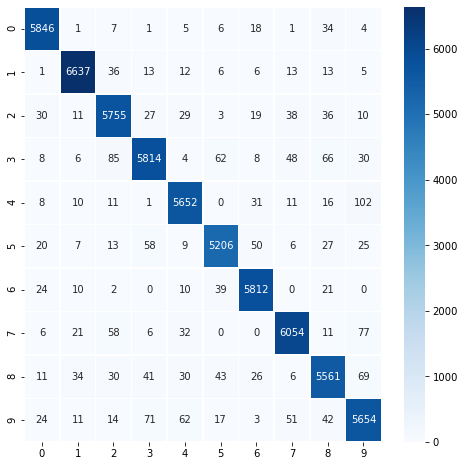

,precision,recall,f1-score,support
0,0.977919,0.987000,0.982438,5923.000000
1,0.983551,0.984426,0.983988,6742.000000
2,0.957411,0.965928,0.961651,5958.000000
3,0.963859,0.948296,0.956014,6131.000000
4,0.966980,0.967477,0.967229,5842.000000
5,0.967298,0.960339,0.963806,5421.000000
6,0.973045,0.982089,0.977546,5918.000000
7,0.972062,0.966321,0.969183,6265.000000
8,0.954350,0.950436,0.952389,5851.000000
9,0.946118,0.950412,0.948260,5949.000000


In [82]:
rfc = RandomForestClassifier(max_depth=50, max_features='auto', n_estimators=500, n_jobs=-1)
kfold = StratifiedKFold(n_splits=3)
y_predict = cross_val_predict(rfc, X_train, y_train, cv=kfold)

cm = confusion_matrix(y_train, y_predict)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidth=0.5)
plt.show()

res = pd.DataFrame(classification_report(y_train, y_predict, output_dict=True)).T
res

## Summery

- A simple case of one-vs-rest is implemented for the digit 5
    - Random forest classifier provides the recall rate of 88%
- A multicalss clasffier has been implemented using random forest classifier
    - The precision and recall rates of the all the digits are greater than or equal to 95%
    - The average accuracy of the model is geater than 96%
    - It seems that the digits 4, 7, 8 are misclassified as 9 atleast 4% of the occurances.
- For further improvement, extra features such as the number of loops a digit contains can be considered.